In [ ]:
#过拟合与欠拟合


In [1]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l


In [2]:
max_degree = 20 #多项式的最大阶数,即最多有20个特征
n_train, n_test = 100, 100 #训练集和测试集的样本数
true_w = np.zeros(max_degree) #初始化权重
true_w.shape

(20,)

In [3]:
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6]) #前4个特征的权重

In [4]:
features = np.random.normal(size=(n_train + n_test, 1)) #生成训练集和测试集的特征
np.random.shuffle(features) #打乱顺序
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1)) #生成多项式特征
for i in range(max_degree):
    #i指的是多项式的阶数
    poly_features[:, i] /= math.gamma(i + 1) #gamma函数指的是阶乘

labels = np.dot(poly_features, true_w) #生成标签
labels += np.random.normal(scale=0.1, size=labels.shape) #加上噪声

In [5]:
true_w, features, poly_features, labels= [torch.tensor(x, dtype=torch.float32)
                                          for x in [true_w, features, poly_features, labels]]#for循环的意思是将列表中的每个元素都转换成torch.tensor

In [6]:
features[:2], poly_features[:2, :], labels[:2] #查看前两个样本的特征和标签


(tensor([[ 0.4270],
         [-1.5609]]),
 tensor([[ 1.0000e+00,  4.2696e-01,  9.1146e-02,  1.2972e-02,  1.3846e-03,
           1.1823e-04,  8.4134e-06,  5.1317e-07,  2.7388e-08,  1.2993e-09,
           5.5473e-11,  2.1531e-12,  7.6608e-14,  2.5160e-15,  7.6731e-17,
           2.1841e-18,  5.8281e-20,  1.4637e-21,  3.4720e-23,  7.8020e-25],
         [ 1.0000e+00, -1.5609e+00,  1.2181e+00, -6.3378e-01,  2.4731e-01,
          -7.7204e-02,  2.0084e-02, -4.4784e-03,  8.7376e-04, -1.5154e-04,
           2.3653e-05, -3.3562e-06,  4.3655e-07, -5.2415e-08,  5.8437e-09,
          -6.0808e-10,  5.9321e-11, -5.4466e-12,  4.7230e-13, -3.8800e-14]]),
 tensor([ 5.3479, -4.5479]))

In [7]:
#评估损失
def evaluate_loss(net, data_iter, loss): #定义损失函数
    metric = d2l.Accumulator(2) #定义一个累加器，用来累加损失函数的和
    for X, y in data_iter:
        out = net(X) #计算输出
        y = y.reshape(out.shape)
        l = loss(out, y) #计算损失
        metric.add(l.sum(), l.numel()) #将损失和样本数加入到累加器中
    return metric[0] / metric[1] #返回平均损失


In [8]:
#定义训练函数
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = nn.MSELoss() #定义损失函数
    input_shape = train_features.shape[-1] #输入的特征数
    #不设置偏置，因为我们已经在多项式特征中实现了它
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False)) #定义网络
    batch_size = min(10, train_labels.shape[0]) #定义批量大小
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1, 1)),
                                batch_size) #定义训练集的迭代器
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1, 1)),
                               batch_size, is_train=False) #定义测试集的迭代器
    trainer = torch.optim.SGD(net.parameters(), lr=0.01) #定义优化器
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test']) #定义动画
    for epoch in range(num_epochs): #开始训练
        d2l.train_epoch_ch3(net, train_iter, loss, trainer) #训练一个迭代周期
        if epoch == 0 or (epoch + 1) % 20 == 0: #每20个迭代周期
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss))) #计算并添加损失
    print('weight:', net[0].weight.data.numpy()) #打印权重


weight: [[ 5.014447   1.2200435 -3.3889143  5.603526 ]]


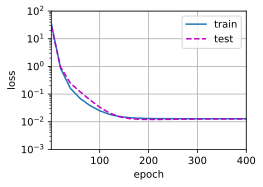

In [12]:
train(poly_features[:n_train, :4], poly_features[n_train:, :4], labels[:n_train],
      labels[n_train:])

weight: [[2.4433696 5.5166025]]


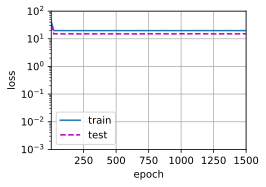

In [13]:
train(poly_features[:n_train, :2], poly_features[n_train:, :2], labels[:n_train],
      labels[n_train:], num_epochs=1500)

weight: [[ 5.022432    1.2881973  -3.4511485   5.2489376   0.15446989  1.0492568
   0.39906546  0.13337576 -0.13192448  0.02505472  0.00680227  0.00605918
  -0.05465304  0.22181326  0.12627418  0.14067973 -0.04231421  0.20912477
  -0.09890483 -0.09914105]]


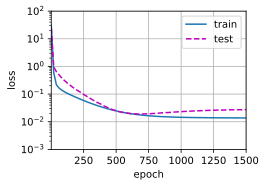

In [15]:
train(poly_features[:n_train, :], poly_features[n_train:, :], labels[:n_train],
      labels[n_train:], num_epochs=1500)
